## 구글 드라이브 연동




In [1]:
# google drive 연동
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# import library

In [61]:
!pip install konlpy
import json, os, pickle, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout,BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 데이터 수집 및 처리

In [3]:
dir = os.chdir('/content/drive/MyDrive/숨고/심재호님(민원 분류)/')

# train set list
train_labels = os.listdir('./data/train')

# test set list
test_labels = os.listdir('./data/validation')

In [4]:
train_label_list = []
train_text_list = []
test_label_list = []
test_text_list = []

for label in train_labels:
    with open('./data/train/'+label+"/"+os.listdir('./data/train/'+label)[0], "r") as js:
        json_result = json.load(js)

    for i in json_result:
        train_text_list.append(i['Q_refined'])
        train_label_list.append(label)

for label in test_labels:
    with open('./data/validation/'+label+"/"+os.listdir('./data/validation/'+label)[0], "r") as js:
        json_result = json.load(js)

    for i in json_result:
        test_text_list.append(i['Q_refined'])
        test_label_list.append(label)

In [5]:
train_total = pd.DataFrame({'label':train_label_list, 'text':train_text_list})
test_total = pd.DataFrame({'label':test_label_list, 'text':test_text_list})

In [6]:
# 양쪽 공백 제거
train_total['text'] = train_total['text'].apply(lambda x : x.strip())
test_total['text'] = test_total['text'].apply(lambda x : x.strip())

In [7]:
# 중복데이터 제거
train_total = train_total.drop_duplicates(['text']).reset_index(drop=True)
test_total = test_total.drop_duplicates(['text']).reset_index(drop=True)

In [8]:
# train set의 label별 데이터 비율 확인(자동차와 안전건설, 교통이 전체의 50프로 이상을 차지)
train_total['label'].value_counts(normalize = True)

자동차               0.288742
안전건설          0.134713
교통                 0.113628
건축허가            0.080739
환경미화            0.054055
공통                0.043405
산림                0.037746
행정                0.033193
복지                 0.029906
문화_체육_관광    0.028998
보건소               0.028575
위생                 0.028138
세무                  0.027924
상하수도             0.024698
경제                 0.022392
농업_축산         0.013321
토지                  0.008777
정보통신           0.001050
Name: label, dtype: float64

In [9]:
# test set의 label별 데이터 비율 확인(자동차와 안전건설, 교통이 전체의 50프로 이상을 차지)
test_total['label'].value_counts(normalize = True)

자동차               0.313060
안전건설          0.128954
교통                 0.111750
건축허가            0.078268
환경미화            0.051954
공통                0.041764
산림                0.036151
행정                0.031883
복지                 0.028696
문화_체육_관광    0.027802
세무                  0.027538
보건소               0.027482
위생                 0.027096
상하수도             0.023678
경제                 0.021604
농업_축산         0.012903
토지                  0.008393
정보통신           0.001026
Name: label, dtype: float64

count    688466.000000
mean         11.680465
std           8.878114
min           1.000000
25%           7.000000
50%           9.000000
75%          13.000000
max         293.000000
Name: text_len, dtype: float64


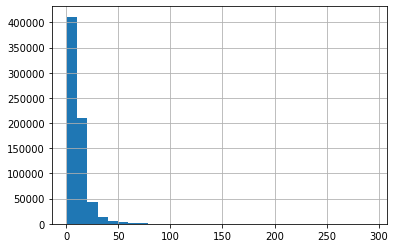

In [10]:
# train set의 문장별 단어 수 분포
train_total['text_len'] = train_total['text'].apply(lambda x : len(x.split(" ")))
train_total['text_len'].hist(bins=30)

print(train_total['text_len'].describe())

count    90676.000000
mean        11.527229
std          8.419499
min          2.000000
25%          7.000000
50%          9.000000
75%         13.000000
max        246.000000
Name: text_len, dtype: float64


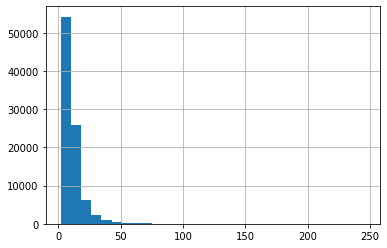

In [11]:
# test set의 문장별 단어 수 분포
test_total['text_len'] = test_total['text'].apply(lambda x : len(x.split(" ")))
test_total['text_len'].hist(bins=30)

print(test_total['text_len'].describe())

## NLP

In [16]:
# 한글 및 공백을 제외한 나머지 제거
train_total['text'] = train_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_total['text'] = train_total['text'].str.replace('^ +', "") # 공백 데이터가 있다면 empty value로 변경
train_total['text'].replace('', np.nan, inplace=True)

test_total['text'] = test_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_total['text'] = test_total['text'].str.replace('^ +', "")
test_total['text'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


## tokenization & encoding

In [ ]:
# label 원핫인코딩 진행
onehot = OneHotEncoder()
Y_train = onehot.fit_transform(train_total['label'].values.reshape(-1,1))
Y_test = onehot.transform(test_total['label'].values.reshape(-1,1))

In [23]:
# stopwords 정의(임의로 설정했으므로, 더 추가 가능)
stopwords = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓".split(" ") 
stopwords = list(set(stopwords + ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']))
stopwords[:10]

['누구', '있', '좋', '그러나', '연관되다', '걍', '응', '한', '앗', '결론을']

In [32]:
# tokenization
okt = Okt()

X_train = []
for sentence in tqdm(train_total['text']):
    tokenized = okt.morphs(sentence, stem=True)
    sentence_stopwords = [word for word in tokenized if not word in stopwords]
    X_train.append(sentence_stopwords)

X_test = []
for sentence in tqdm(test_total['text']):
    tokenized = okt.morphs(sentence, stem=True)
    sentence_stopwords = [word for word in tokenized if not word in stopwords]
    X_test.append(sentence_stopwords)

100%|██████████| 90676/90676 [12:03<00:00, 125.36it/s]


In [36]:
# encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25547
등장 빈도가 2번 이하인 희귀 단어의 수: 2633
단어 집합에서 희귀 단어의 비율: 10.30649391317963
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.039104349625984865


In [37]:
# 희귀단어가 적으므로 전체 단어 모두 사용해도 될 것으로 판단
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 25548


In [38]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [40]:
# padding(최대 길이 50으로 맞춤)
X_train = pad_sequences(X_train, maxlen=50)
X_test = pad_sequences(X_test, maxlen=50)

In [82]:
# 결과물 중간 저장
if not os.path.exists("./processed_data"):
    os.makedirs("./processed_data")

with open('./processed_data/stopwords.pickle', 'wb') as f:
    pickle.dump(stopwords, f)

with open('./processed_data/onehotencoder.pickle', 'wb') as f:
    pickle.dump(onehot, f)
    
with open('./processed_data/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('./processed_data/train_x.pickle', 'wb') as f:
    pickle.dump(X_train, f)

with open('./processed_data/train_y.pickle', 'wb') as f:
    pickle.dump(Y_train, f)

with open('./processed_data/test_x.pickle', 'wb') as f:
    pickle.dump(X_test, f)

with open('./processed_data/test_y.pickle', 'wb') as f:
    pickle.dump(Y_test, f)

In [62]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.2, stratify=Y_train)

## LSTM Classifier 정의 및 학습

In [56]:
# 모델의 첫 input으로 선언하는 layer로, input data의 차원 수와 동일하게 shape을 주면 됩니다
model_input = Input(shape=50)

# 모델의 첫 embedding layer로, output_dim은 해당 층에서 출력할 벡터 사이즈. input_dim은 현재 데이터의 전체 단어 종류 수, input_length는 input data의 차원 수라고 보시면 됩니다
model_emb = Embedding(output_dim=32, input_dim=vocab_size, input_length=50)(model_input)

# hidden node 수가 64개인 LSTM 층을 선언합니다
model_lstm = LSTM(64)(model_emb)

# hidden node 수가 64개인 dense 층을 선언합니다, he 초기화를 사용했습니다
model_dense = Dense(64, kernel_initializer='he_normal')(model_lstm)

# Relu 활성함수를 사용합니다
model_dense = ReLU()(model_dense)

# 최종 18개 종류로 분류하기 위한 softmax층입니다.
model_output = Dense(18, activation='softmax')(model_dense)

# 위 선언한 모델을 패키징합니다.
model = Model(inputs=[model_input], outputs=[model_output])

model.summary() # 모델 전체 아키텍처 출력

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 32)            817536    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_5 (ReLU)              (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 18)                1170      
                                                                 
Total params: 847,698
Trainable params: 847,698
Non-trainab

In [130]:
# 학습률입니다.
lr = 0.001
# 최적화 기법은 Adam입니다.
optimizer = optimizers.Adam(learning_rate=lr)

# model의 loss function, 사용할 optimizer, metirc 정의
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']) 

In [67]:
# 학습 중 최상의 모델을 저장할 경로
best_weights_file="weights.best.hdf5"

# 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# model 학습 설정 및 학습 진행
history = model.fit(X_train, Y_train,
        batch_size=128,
        epochs=200,
        callbacks=[checkpoint, es],
        verbose=1,
        validation_data=[X_val,Y_val])

Epoch 1/200
4300/4303 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8783
Epoch 1: val_loss improved from inf to 0.49672, saving model to weights.best.hdf5
4303/4303 [==============================] - 34s 8ms/step - loss: 0.3900 - accuracy: 0.8783 - val_loss: 0.4967 - val_accuracy: 0.8538
Epoch 2/200
4297/4303 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8962
Epoch 2: val_loss improved from 0.49672 to 0.47908, saving model to weights.best.hdf5
4303/4303 [==============================] - 32s 7ms/step - loss: 0.3342 - accuracy: 0.8962 - val_loss: 0.4791 - val_accuracy: 0.8621
Epoch 3/200
4302/4303 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.9053
Epoch 3: val_loss improved from 0.47908 to 0.47191, saving model to weights.best.hdf5
4303/4303 [==============================] - 32s 7ms/step - loss: 0.3055 - accuracy: 0.9053 - val_loss: 0.4719 - val_accuracy: 0.8669
Epoch 4/200
4297/4303 [========================

## Evaluation

In [69]:
# 저장된 model load
best_weights_file="weights.best.hdf5"
model.load_weights(best_weights_file)

#분리해둔 test set에 대하여 모델 정확도 반환
print('\nAccuracy: {:.4f}'.format(model.evaluate(X_test, Y_test)[1])) 

2834/2834 [==============================] - 9s 3ms/step - loss: 0.4354 - accuracy: 0.8822

Accuracy: 0.8822


## 실제 테스트(실제 활용만 하고 싶으면 이 부분만 실행하시면 됩니다)

In [169]:
!pip install konlpy
import pickle, re, os
from konlpy.tag import Okt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout,BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

# 작업 경로입니다.
path = '/content/drive/MyDrive/숨고/심재호님(민원 분류)/'

sample = input("민원을 입력하세요 :")

# 양쪽 공백 제거
test_sentence = sample.strip()

# 한글 및 공백을 제외한 나머지 제거
test_sentence = test_sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_sentence = test_sentence.replace('^ +', "") # 공백 데이터가 있다면 empty value로 변경

# tokenization
with open(path + 'processed_data/stopwords.pickle', 'rb') as f:
    stopwords = pickle.load(f)

okt = Okt()
tokenized_sentence = okt.morphs(test_sentence, stem=True)
sentence_stopwords = [word for word in tokenized_sentence if not word in stopwords]

with open(path + 'processed_data/tokenizer.pickle', 'rb') as f:
    tokenizer_test = pickle.load(f)

test_sentence = tokenizer.texts_to_sequences([sentence_stopwords])

# padding(최대 길이 50으로 맞춤)
test_sentence = pad_sequences(test_sentence, maxlen=50)

# 모델 로드
model_input = Input(shape=50)
model_emb = Embedding(output_dim=32, input_dim=vocab_size, input_length=50)(model_input)
model_lstm = LSTM(64)(model_emb)
model_dense = Dense(64, kernel_initializer='he_normal')(model_lstm)
model_dense = ReLU()(model_dense)
model_output = Dense(18, activation='softmax')(model_dense)
model = Model(inputs=[model_input], outputs=[model_output])
best_weights_file="weights.best.hdf5"
model.load_weights(path + best_weights_file)

with open(path + 'processed_data/onehotencoder.pickle', 'rb') as f:
    onehotencoder = pickle.load(f)

predict_result = onehotencoder.categories_[0][np.argmax(model.predict(test_sentence))]

# 예측
print("\n"*3)
print(f"입력된 민원 : {sample}")
print(f"다음 부서로 할당되었습니다 - {predict_result}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
민원을 입력하세요 :얼마전 길고양이가 죽어있는 것을 발견했습니다. 처리 부탁드립니다.
1/1 [==============================] - 0s 371ms/step




입력된 민원 : 얼마전 길고양이가 죽어있는 것을 발견했습니다. 처리 부탁드립니다.
다음 부서로 할당되었습니다 : 농업_축산
